# When did the pandemic start and stop for financial markets?  K-means analysis of daily financial data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Load and normalize data between 2018 and 2021

In [6]:
# Load data
base_path = 'C:/Users/jacke/Documents/Data Projects/'

filenames = ["MutualFund prices - A-E.csv", "MutualFund prices - F-K.csv", "MutualFund prices - L-P.csv", "MutualFund prices - Q-Z.csv", "MutualFunds.csv", "ETF prices.csv", "ETFs.csv"]

price_data = pd.read_csv(base_path + filenames[5])
price_data['price_date'] = pd.to_datetime(price_data['price_date'])
data = price_data.pivot(index='price_date', columns='fund_symbol', values='adj_close')

# Drop data before 2018
data = data[data.index >= '2018-01-01']

# Drop columns with all NaN values
data.dropna(axis=1, how='any', inplace=True)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

Plot an elbow curve to determine how many clusters would be appropriate

c:\Users\jacke\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


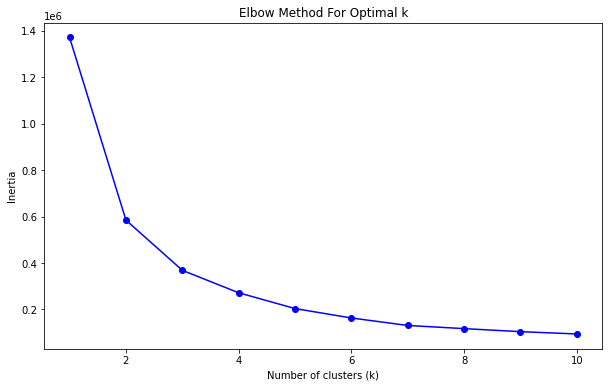

In [18]:
# Determine the optimal number of clusters using the elbow method
OMP_NUM_THREADS=4
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

Selecting k=3 as our number of clusters, proceed with the k-means clustering

In [31]:
# Fit K-means with the optimal number of clusters (In this case, k=3)
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(normalized_data)
labels = kmeans.labels_

# Add the cluster labels to the original data
data['Cluster'] = labels

print(data['Cluster'].value_counts())

2    541
1    255
0    190
Name: Cluster, dtype: int64


Perform PCA to reduce the data to 2-d to visualize the clusters and plot it

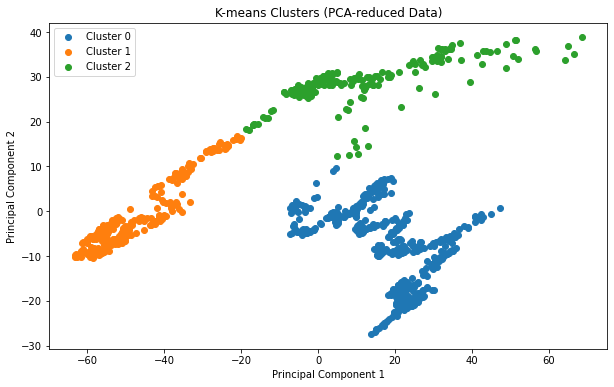

In [15]:
# Visualize the clusters using PCA (to reduce to 2D for visualization)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(normalized_data)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['Cluster'] = labels

plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    clustered_data = pc_df[pc_df['Cluster'] == cluster]
    plt.scatter(clustered_data['PC1'], clustered_data['PC2'], label=f'Cluster {cluster}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clusters (PCA-reduced Data)')
plt.legend()
plt.show()

3 distinct categories can be seen, indicating a significant change in behavior of the markets between the three periods identified.

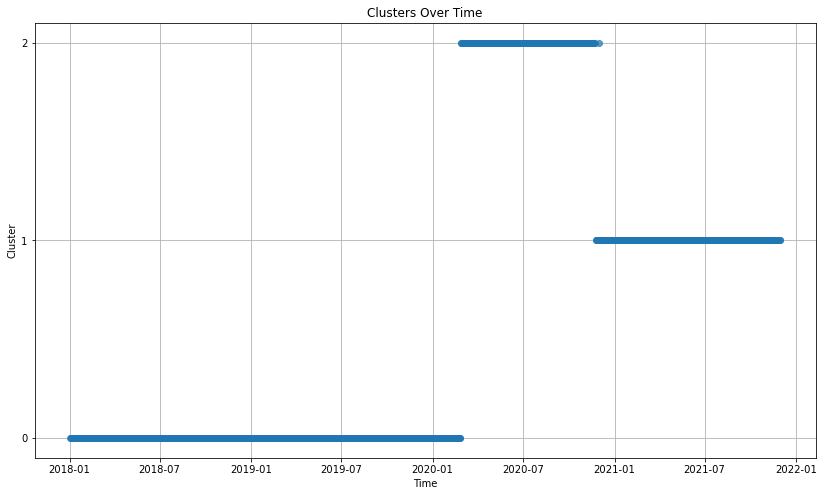

In [20]:
# Plot the clusters over time
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Cluster'], marker='o', linestyle='', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Cluster')
plt.title('Clusters Over Time')
plt.yticks(range(optimal_k))  # Ensure y-axis only has the cluster labels
plt.grid(True)
plt.show()

Plotting the clusters by time, we can see a distinct period around when the pandemic began, and when the markets entered post-pandemic behavior

In [30]:
# Group by 'Cluster' and find the first date observed in each cluster
first_dates = data.groupby('Cluster').apply(lambda df: df.index.min())

# Print the first date observed within each cluster
for cluster, date in first_dates.items():
    print(f"The first date observed in cluster {cluster} is {data.iloc[date][0]}")

The first date observed in cluster 0 is 2018-01-02 00:00:00
The first date observed in cluster 1 is 2020-11-24 00:00:00
The first date observed in cluster 2 is 2020-02-27 00:00:00


According to the k-means clustering, the behavior of the markets first changed in Feburary 27 of 2020, and then again in November 24 of the same year; albeit not to a pre-pandemic norm but rather to a new post-pandemic regime.  While the start of the pandemic lines up with the beginning of the official recession in the United States, we can see that the markets retained their pandemic variance levels until several months after the recession officially ended.